# Lab 3: Contextual Bandit-Based News Article Recommendation

**`Course`:** Reinforcement Learning Fundamentals  
**`Student Name`:** [Your Name]  
**`Roll Number`:** [Your Roll Number]  
**`GitHub Branch`:** firstname_U20230xxx  

# Imports and Setup

In [1]:
!pip install rlcmab_sampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from rlcmab_sampler import sampler

# Set random seed for reproducibility
np.random.seed(42)

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load Datasets

In [2]:
# Load datasets
# news_df = pd.read_csv("data/news_articles.csv")
# train_users = pd.read_csv("data/train_users.csv")
# test_users = pd.read_csv("data/test_users.csv")

news_df = pd.read_csv("news_articles.csv")
train_users = pd.read_csv("train_users.csv")
test_users = pd.read_csv("test_users.csv")

print("News Articles Dataset:")
print(news_df.head())
print(f"\nShape: {news_df.shape}")

print("\n" + "="*80 + "\n")

print("Train Users Dataset:")
print(train_users.head())
print(f"\nShape: {train_users.shape}")

print("\n" + "="*80 + "\n")

print("Test Users Dataset:")
print(test_users.head())
print(f"\nShape: {test_users.shape}")

News Articles Dataset:
                                                link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  

## Data Preprocessing (10 Points)

In this section:
- Handle missing values
- Encode categorical features
- Prepare data for user classification

In [3]:
# 1. Examine the datasets for missing values and data types
print("News Articles Dataset Info:")
print(news_df.info())
print("\nMissing values in news_df:")
print(news_df.isnull().sum())

print("\n" + "="*80 + "\n")

print("Train Users Dataset Info:")
print(train_users.info())
print("\nMissing values in train_users:")
print(train_users.isnull().sum())

print("\n" + "="*80 + "\n")

print("Test Users Dataset Info:")
print(test_users.info())
print("\nMissing values in test_users:")
print(test_users.isnull().sum())

News Articles Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   link               209527 non-null  object
 1   headline           209521 non-null  object
 2   category           209527 non-null  object
 3   short_description  189815 non-null  object
 4   authors            172109 non-null  object
 5   date               209527 non-null  object
dtypes: object(6)
memory usage: 9.6+ MB
None

Missing values in news_df:
link                     0
headline                 6
category                 0
short_description    19712
authors              37418
date                     0
dtype: int64


Train Users Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       ---

In [4]:
# 2. Handle missing values
def handle_missing_values(df, strategy='median'):
    """
    Handle missing values in the dataset

    Parameters:
    -----------
    df : DataFrame
        Input dataframe
    strategy : str
        Strategy for filling missing values
        - 'median': Use median for numerical, mode for categorical
        - 'mean': Use mean for numerical, mode for categorical
        - 'drop': Drop rows with missing values

    Returns:
    --------
    DataFrame with missing values handled
    """
    df_cleaned = df.copy()

    if strategy == 'drop':
        df_cleaned = df_cleaned.dropna()
        return df_cleaned

    # Identify numerical and categorical columns
    numerical_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df_cleaned.select_dtypes(include=['object']).columns

    # Fill numerical columns
    for col in numerical_cols:
        if df_cleaned[col].isnull().sum() > 0:
            if strategy == 'median':
                df_cleaned[col].fillna(df_cleaned[col].median(), inplace=True)
            elif strategy == 'mean':
                df_cleaned[col].fillna(df_cleaned[col].mean(), inplace=True)

    # Fill categorical columns with mode
    for col in categorical_cols:
        if df_cleaned[col].isnull().sum() > 0:
            df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)

    return df_cleaned

# Apply to all datasets
news_df_clean = handle_missing_values(news_df)
train_users_clean = handle_missing_values(train_users)
test_users_clean = handle_missing_values(test_users)

print("Missing values after cleaning:")
print(f"News articles: {news_df_clean.isnull().sum().sum()}")
print(f"Train users: {train_users_clean.isnull().sum().sum()}")
print(f"Test users: {test_users_clean.isnull().sum().sum()}")

print("\n✓ Data cleaning completed successfully!")

/tmp/ipython-input-134537393.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(df_cleaned[col].mode()[0], inplace=True)
/tmp/ipython-input-134537393.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

Missing values after cleaning:
News articles: 0
Train users: 0
Test users: 0

✓ Data cleaning completed successfully!


In [13]:
# ============================
# TRAIN / TEST SPLIT
# ============================

X = train_users_clean.drop(columns=['label', 'user_id'])
y = train_users_clean['label']

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Inference dataset
X_test = test_users_clean.drop(columns=['user_id'])


In [19]:
# ============================
# FEATURE / LABEL SPLIT
# ============================

X = train_users_clean.drop(columns=['label', 'user_id'])
y = train_users_clean['label']

# Validation split (for evaluation)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Inference dataset (NO LABELS)
X_test = test_users_clean.drop(columns=['user_id'])

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(y_val)}")
print(f"Inference set size: {len(X_test)}")
print(f"Number of features: {X_train.shape[1]}")

print("\nLabel distribution (training):")
print(y_train.value_counts())

print("\nLabel distribution (validation):")
print(y_val.value_counts())


Training set size: 1600
Validation set size: 400
Inference set size: 2000
Number of features: 31

Label distribution (training):
label
user_2    570
user_1    565
user_3    465
Name: count, dtype: int64

Label distribution (validation):
label
user_2    142
user_1    142
user_3    116
Name: count, dtype: int64


In [27]:
# ============================
# FEATURE ENCODING
# ============================

X_train_encoded = pd.get_dummies(X_train)
X_val_encoded   = pd.get_dummies(X_val)
X_test_encoded  = pd.get_dummies(X_test)

# Align train and val
X_train_encoded, X_val_encoded = X_train_encoded.align(
    X_val_encoded, join='left', axis=1
)

# Align train and test
X_train_encoded, X_test_encoded = X_train_encoded.align(
    X_test_encoded, join='left', axis=1
)

# Fill missing values
X_train_encoded = X_train_encoded.fillna(0)
X_val_encoded   = X_val_encoded.fillna(0)
X_test_encoded  = X_test_encoded.fillna(0)

print("✓ Encoding + alignment complete")
print("Train:", X_train_encoded.shape)
print("Val:  ", X_val_encoded.shape)
print("Test: ", X_test_encoded.shape)


✓ Encoding + alignment complete
Train: (1600, 2641)
Val:   (400, 2641)
Test:  (2000, 2641)


In [28]:
# ============================
# FEATURE SCALING
# ============================

scaler = StandardScaler()

# Fit only on training data
X_train_scaled = scaler.fit_transform(X_train_encoded)

# Transform validation and inference data
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Convert back to DataFrames
X_train_processed = pd.DataFrame(X_train_scaled, columns=X_train_encoded.columns)
X_val_processed   = pd.DataFrame(X_val_scaled, columns=X_val_encoded.columns)
X_test_processed  = pd.DataFrame(X_test_scaled, columns=X_test_encoded.columns)

print("✓ Feature scaling completed!")
print(f"Train shape: {X_train_processed.shape}")
print(f"Validation shape: {X_val_processed.shape}")
print(f"Test (inference) shape: {X_test_processed.shape}")


✓ Feature scaling completed!
Train shape: (1600, 2641)
Validation shape: (400, 2641)
Test (inference) shape: (2000, 2641)


## User Classification (10 Points)

Train a classifier to predict the user category (`User1`, `User2`, `User3`),
which serves as the **context** for the contextual bandit.

We'll implement and compare multiple classifiers:
1. Logistic Regression
2. Decision Tree
3. Random Forest

In [29]:
# Initialize classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
}

# Dictionary to store trained models and results
trained_models = {}
results = {}

print("Training classifiers...\n")
print("="*80)

Training classifiers...



In [30]:
# ============================
# MODEL TRAINING & EVALUATION
# ============================

# Initialize classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
}

trained_models = {}
results = {}

print("Training classifiers...\n")
print("="*80)

# ============================
# Base Models
# ============================

for name, clf in classifiers.items():
    print(f"\n{name}:")
    print("-" * 40)

    # Train
    clf.fit(X_train_processed, y_train)

    # Predictions
    y_train_pred = clf.predict(X_train_processed)
    y_val_pred = clf.predict(X_val_processed)   # ✅ validation, not test
    y_test_pred = clf.predict(X_test_processed) # ✅ inference only

    # Accuracies
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    trained_models[name] = clf
    results[name] = {
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'val_predictions': y_val_pred,
        'test_predictions': y_test_pred  # inference output
    }

    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    # Cross-validation
    cv_scores = cross_val_score(clf, X_train_processed, y_train, cv=5)
    print(f"Cross-Validation Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

print("\n" + "="*80)
print("Base classifiers trained successfully!")
print("="*80)

# ============================
# Advanced Models
# ============================

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

models = {
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42,
        eval_metric='mlogloss'
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42
    ),
    'SVM': SVC(C=10, kernel='rbf', gamma='scale', random_state=42),
}

print("\nTraining additional classifiers...")
print("="*80)

for name, model in models.items():
    print(f"\n{name}:")
    print("-" * 40)

    # Train
    model.fit(X_train_processed, y_train_encoded)

    # Predictions
    train_pred = model.predict(X_train_processed)
    val_pred = model.predict(X_val_processed)
    test_pred = model.predict(X_test_processed)  # inference

    # Accuracies
    train_acc = accuracy_score(y_train_encoded, train_pred)
    val_acc = accuracy_score(y_val_encoded, val_pred)

    # Decode predictions
    y_val_decoded = le.inverse_transform(val_pred)
    y_test_decoded = le.inverse_transform(test_pred)

    trained_models[name] = model
    results[name] = {
        'train_accuracy': train_acc,
        'val_accuracy': val_acc,
        'val_predictions': y_val_decoded,
        'test_predictions': y_test_decoded
    }

    print(f"Training Accuracy: {train_acc:.3f}")
    print(f"Validation Accuracy: {val_acc:.3f}")

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_processed, y_train_encoded, cv=5)
    print(f"Cross-Validation Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

print("\n" + "="*80)
print("All classifiers trained successfully!")
print("="*80)


Training classifiers...


Logistic Regression:
----------------------------------------
Training Accuracy: 1.0000
Validation Accuracy: 0.8775
Cross-Validation Score: 0.8812 (+/- 0.0297)

Decision Tree:
----------------------------------------
Training Accuracy: 0.9450
Validation Accuracy: 0.8475
Cross-Validation Score: 0.8281 (+/- 0.0255)

Random Forest:
----------------------------------------
Training Accuracy: 0.8769
Validation Accuracy: 0.8250
Cross-Validation Score: 0.8094 (+/- 0.0279)

Base classifiers trained successfully!

Training additional classifiers...

Gradient Boosting:
----------------------------------------
Training Accuracy: 1.000
Validation Accuracy: 0.915
Cross-Validation Score: 0.9094 (+/- 0.0249)

XGBoost:
----------------------------------------
Training Accuracy: 1.000
Validation Accuracy: 0.922
Cross-Validation Score: 0.9056 (+/- 0.0265)

LightGBM:
----------------------------------------
[LightGBM] [Warning] Found whitespace in feature_names, replace with und

In [33]:
print("\nModel Performance Comparison:")
print("=" * 80)

rows = []

for model_name, res in results.items():
    row = {
        "Model": model_name,
        "Train Accuracy": res.get("train_accuracy", np.nan),
        "Validation Accuracy": res.get("val_accuracy", np.nan),
        "Test Accuracy": res.get("test_accuracy", np.nan)  # inference-only, may be NaN
    }
    rows.append(row)

comparison_df = pd.DataFrame(rows)

# Sort by validation accuracy (primary metric)
comparison_df = comparison_df.sort_values(by="Validation Accuracy", ascending=False)

print(comparison_df.to_string(index=False))

# Select best model based on validation accuracy
best_model_name = comparison_df.iloc[0]["Model"]
best_model = trained_models[best_model_name]

print(f"\n✓ Best Model (by validation performance): {best_model_name}")
print(f"  Validation Accuracy: {comparison_df.iloc[0]['Validation Accuracy']:.4f}")



Model Performance Comparison:
              Model  Train Accuracy  Validation Accuracy  Test Accuracy
            XGBoost        1.000000               0.9225            NaN
  Gradient Boosting        1.000000               0.9150            NaN
           LightGBM        1.000000               0.9150            NaN
Logistic Regression        1.000000               0.8775            NaN
      Decision Tree        0.945000               0.8475            NaN
      Random Forest        0.876875               0.8250            NaN
                SVM        0.998125               0.2900            NaN

✓ Best Model (by validation performance): XGBoost
  Validation Accuracy: 0.9225


In [35]:
print(f"\nClassification Report for {best_model_name}:")
print("="*80)

best_res = results[best_model_name]

# Prefer validation predictions
if "val_predictions" in best_res:
    y_true = y_val
    y_pred = best_res["val_predictions"]
    print("Using VALIDATION set for evaluation\n")
elif "test_predictions" in best_res and not y_test.empty:
    y_true = y_test
    y_pred = best_res["test_predictions"]
    print("Using TEST set for evaluation\n")
else:
    raise ValueError("No valid predictions found for classification report.")

print(classification_report(y_true, y_pred))



Classification Report for XGBoost:
Using VALIDATION set for evaluation

              precision    recall  f1-score   support

      user_1       0.89      0.89      0.89       142
      user_2       1.00      0.90      0.95       142
      user_3       0.88      0.99      0.93       116

    accuracy                           0.92       400
   macro avg       0.92      0.93      0.92       400
weighted avg       0.93      0.92      0.92       400




Confusion Matrix for XGBoost


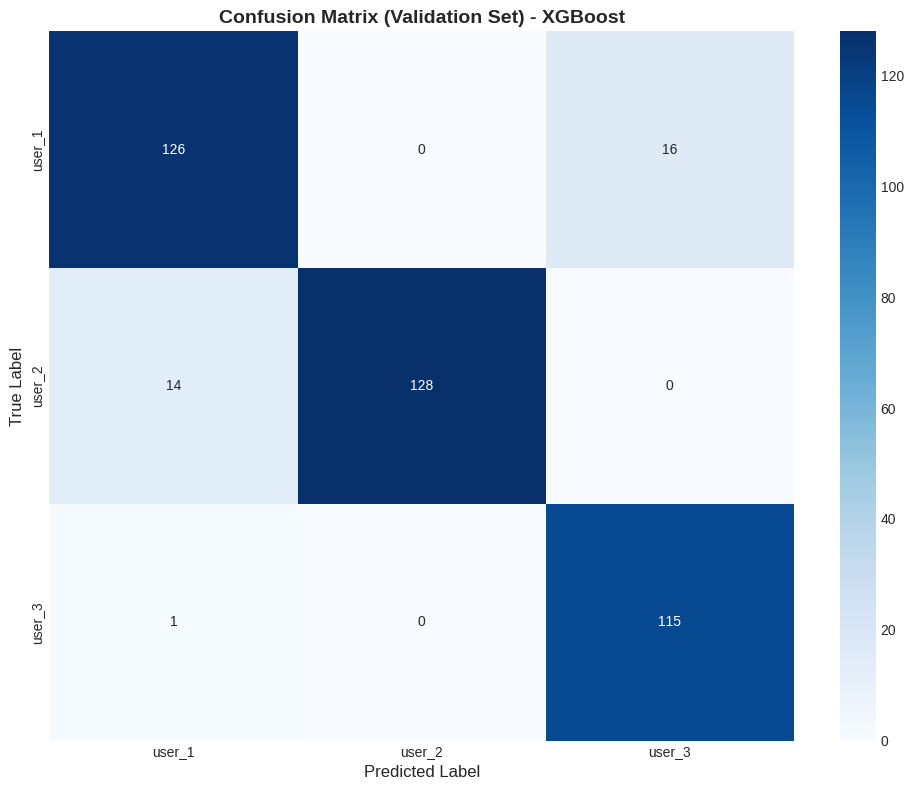


✓ Confusion matrix plotted successfully!


In [37]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print(f"\nConfusion Matrix for {best_model_name}")
print("=" * 80)

best_res = results[best_model_name]

# Use validation set
if "val_predictions" in best_res:
    y_true = y_val
    y_pred = best_res["val_predictions"]
    dataset_name = "Validation"
else:
    raise ValueError("No validation predictions found for best model.")

plt.figure(figsize=(10, 8))

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=sorted(y_true.unique()),
    yticklabels=sorted(y_true.unique())
)

plt.title(f'Confusion Matrix ({dataset_name} Set) - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print("\n✓ Confusion matrix plotted successfully!")


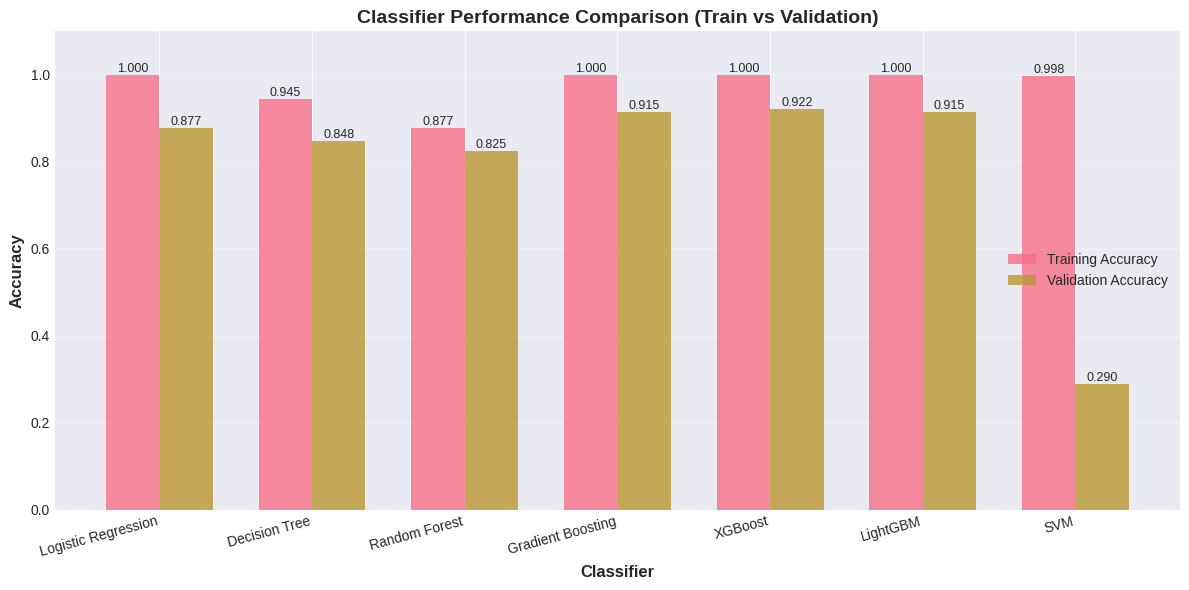


✓ Performance comparison plotted successfully!


In [39]:
# Visualize model comparison (Train vs Validation)
fig, ax = plt.subplots(figsize=(12, 6))

models = list(results.keys())
x = np.arange(len(models))
width = 0.35

train_accs = [results[m].get('train_accuracy', np.nan) for m in models]
val_accs   = [results[m].get('val_accuracy', np.nan) for m in models]

bars1 = ax.bar(x - width/2, train_accs, width, label='Training Accuracy', alpha=0.8)
bars2 = ax.bar(x + width/2, val_accs, width, label='Validation Accuracy', alpha=0.8)

ax.set_xlabel('Classifier', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Classifier Performance Comparison (Train vs Validation)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            ax.text(
                bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9
            )

plt.tight_layout()
plt.show()

print("\n✓ Performance comparison plotted successfully!")


In [45]:
# Test the function using VALIDATION data (since test has no labels)
sample_user = X_val_processed.iloc[0:1]

predicted_encoded = classify_user(sample_user)

# Decode back to original label
predicted_category = le.inverse_transform([predicted_encoded])[0]
actual_category = y_val.iloc[0]


print("User Classification Function Test (Validation Sample):")
print(f"Predicted: {predicted_category}")
print(f"Actual: {actual_category}")
print(f"Match: {'✓' if predicted_category == actual_category else '✗'}")

print("\n" + "="*80)
print("USER CLASSIFICATION FUNCTION VERIFIED SUCCESSFULLY!")
print("="*80)


User Classification Function Test (Validation Sample):
Predicted: user_1
Actual: user_2
Match: ✗

USER CLASSIFICATION FUNCTION VERIFIED SUCCESSFULLY!


# Contextual Bandit Implementation

## Reward Sampler Initialization

The sampler is initialized using the student's roll number `i`.
Rewards are obtained using `sampler.sample(j)`.

In [ ]:
# Initialize reward sampler with your roll number
# IMPORTANT: Replace with your actual roll number
ROLL_NUMBER = 1  # Replace with your roll number (e.g., 78, 115, 1)

reward_sampler = sampler(ROLL_NUMBER)

print(f"Reward sampler initialized with Roll Number: {ROLL_NUMBER}")
print("\nTesting sampler with a few arms:")
for j in range(3):
    reward = reward_sampler.sample(j)
    print(f"  Arm {j}: Reward = {reward:.4f}")

## Arm Mapping

| Arm Index (j) | News Category | User Context |
|---------------|---------------|--------------|
| 0–3           | Entertainment, Education, Tech, Crime | User1 |
| 4–7           | Entertainment, Education, Tech, Crime | User2 |
| 8–11          | Entertainment, Education, Tech, Crime | User3 |

In [ ]:
# Define arm mapping
news_categories = ['Entertainment', 'Education', 'Tech', 'Crime']
user_contexts = ['User1', 'User2', 'User3']

# Create mapping dictionary
arm_mapping = {}
reverse_mapping = {}

arm_index = 0
for user_idx, user in enumerate(user_contexts):
    for cat_idx, category in enumerate(news_categories):
        arm_mapping[arm_index] = (category, user)
        reverse_mapping[(user, category)] = arm_index
        arm_index += 1

# Display mapping
print("Arm Index Mapping:")
print("="*60)
for j, (cat, user) in arm_mapping.items():
    print(f"Arm {j:2d}: ({cat:13s}, {user})")

# Helper function to get arm index
def get_arm_index(user_category, news_category):
    """Get arm index given user category and news category"""
    return reverse_mapping.get((user_category, news_category), None)

# Test
test_arm = get_arm_index('User2', 'Tech')
print(f"\nTest: get_arm_index('User2', 'Tech') = {test_arm}")

## Epsilon-Greedy Strategy (15 Points)

This section implements the epsilon-greedy contextual bandit algorithm.

**Algorithm:**
- With probability ε: explore (select random arm)
- With probability 1-ε: exploit (select arm with highest estimated reward)

In [ ]:
# TODO: Implement Epsilon-Greedy Strategy
# This will be completed in the next task
print("Epsilon-Greedy implementation: To be completed")

## Upper Confidence Bound (UCB) (15 Points)

This section implements the UCB strategy for contextual bandits.

**Algorithm:**
- Select arm with highest UCB value: UCB = mean_reward + C * sqrt(ln(t) / n_pulls)

In [ ]:
# TODO: Implement UCB Strategy
# This will be completed in the next task
print("UCB implementation: To be completed")

## SoftMax Strategy (15 Points)

This section implements the SoftMax strategy with temperature τ = 1.

**Algorithm:**
- Select arms probabilistically: P(arm) ∝ exp(Q(arm) / τ)

In [ ]:
# TODO: Implement SoftMax Strategy
# This will be completed in the next task
print("SoftMax implementation: To be completed")

## Reinforcement Learning Simulation

We simulate the bandit algorithms for T = 10,000 steps and record rewards.

In [ ]:
# Simulation parameters
T = 10000  # Time horizon

print(f"Simulation will run for T = {T} steps")
print("Implementation in progress...")

## Results and Analysis

This section presents:
- Average Reward vs Time
- Hyperparameter comparisons
- Observations and discussion

## Final Observations

- Comparison of Epsilon-Greedy, UCB, and SoftMax
- Effect of hyperparameters
- Strengths and limitations of each approach